# Mineria de Datos - Grado en Estadistica y Empresa

# Práctica 1 - Andrés Rubio Lafuente

## Datos, Paquetes y Funciones

Cargamos los paquetes necesarios para realizar la practica y definimos las funciones que se han usado en la practica.

In [ ]:
# Paquetes basicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import calendar

# Preproceso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelo arbol
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score
import graphviz

# Redes neuronales
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Funcion para transformar la variable 'MES' en categorica
def mesas(datos):
    mes = datos['MES'].dt.month
    meses = [calendar.month_name[i] for i in range(1, 13)]
    datos['MES'] = pd.cut(mes, bins = list(range(1,14)), labels = meses, right = False)
    return datos

# Funcion para ver que columnas del dataset estan muy correladas.
def col_corr(mcorr,X):
  t = []
  s = []
  c = []
  b = X.shape[1] - 1
  d = mcorr.columns
  umbral = 0.95
  for i in range(b):
    for j in range(b):
      if mcorr.iloc[i,j] >= umbral and d[i] != d[j]:
        t.append(d[i])
        s.append(d[j])
        c.append(mcorr.iloc[i,j])
  correlados = pd.DataFrame({'Columna1':t, 'Columna2':s, 'Correlacion': c})
  correlados[['Columna1', 'Columna2']] = pd.DataFrame(np.sort(correlados [['Columna1', 'Columna2']].values, axis = 1), index = correlados.index)
  corre = correlados.drop_duplicates()
  return(corre)

# Funcion para determinar que variables son categoricas.
def cata(X):
  umbral = 12
  t = []
  for col in X.columns:
    cat = X[col].nunique()
    if cat <= umbral:
       t.append((col, cat))
  result = pd.DataFrame(t, columns = ['VARIABLE','NUMERO CATEGORIAS'])
  return result

# Funcion para graficar la curva ROC-AUC.
def roc_auc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize = (8,6))
    plt.title('ROC-AUC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Tasa Verdaderos Positivos')
    plt.xlabel('Tasa Falsos Positivos')
    plt.show()

# Funcion para graficar el accuracy obtenido en funcion del umbral para el arbol de clasificacion.
def umbral_arbol():
  umbral = np.arange(0,1,0.05)
  acc = []
  for i in umbral:
    y_umbral_test = 1*(y_pred_test > i)
    accuracy_arbol = accuracy_score(y_test, y_umbral_test)
    acc.append((i,accuracy_arbol))
  tabla_acc = pd.DataFrame(acc, columns = ['Umbral','Accuracy'])
  mejor_acc = np.max(tabla_acc['Accuracy'])
  loc_mejor_acc = tabla_acc.loc[tabla_acc['Accuracy'].idxmax()]
  mejor_umbral = loc_mejor_acc['Umbral']
  plt.figure(figsize = (10,6))
  plt.plot(tabla_acc['Umbral'],tabla_acc['Accuracy'])
  plt.xticks(umbral)
  plt.xlabel('Umbral')
  plt.ylabel('Accuracy')
  plt.show()
  print(f'El mejor umbral = {mejor_umbral}, para el cual se obtiene una accuracy = {mejor_acc}')

# Funcion para graficar el accuracy obtenido en funcion del umbral para el modelo de redes neuronales.
def umbral_nn():
  umbral = np.arange(0,1,0.05)
  acc = []
  for i in umbral:
    pred_test = (y_pred_test > i).astype("int32").flatten()
    pred_test = np.array(pred_test)
    accuracy_nn = accuracy_score(y_test, pred_test)
    acc.append((i, accuracy_nn))
  tabla_acc = pd.DataFrame(acc, columns = ['Umbral','Accuracy'])
  mejor_acc = np.max(tabla_acc['Accuracy'])
  loc_mejor_acc = tabla_acc.loc[tabla_acc['Accuracy'].idxmax()]
  mejor_umbral = loc_mejor_acc['Umbral']
  plt.figure(figsize = (10,6))
  plt.plot(tabla_acc['Umbral'],tabla_acc['Accuracy'])
  plt.xticks(umbral)
  plt.xlabel('Umbral')
  plt.ylabel('Accuracy')
  plt.show()
  print(f'El mejor umbral = {mejor_umbral}, para el cual se obtiene una accuracy = {mejor_acc}')

Cargamos los datos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Transformamos la variable 'MES', que contiene el tiempo de registro de la instancia, por el mes que le corresponda, teniendo asi 12 categorias.

In [ ]:
datos = pd.read_csv('/content/drive/MyDrive/Mineria de Datos/Practica Individual/datos_practica_small_20k_con_mes.csv')
datos['MES'] = pd.to_datetime(datos['MES'], format='%Y%m')
datos['MES'] = datos['MES'].dt.to_period('M')
mesas(datos)
datos[:2]

,MES,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,MB_MENSUALES,EDAD,NUM_LLAMADAS_RED_PROPIA,...,MINUTOS_LLAMADAS_MENSUALES,NUM_DIAS_BUNDLE,KPI_IMPUESTOS,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,TARGET
0,January,232.121597,10.186000,0.000000,4523.0,1183.0,28.0,232.121597,39.0,54.0,...,21.683399,0,1.7678,0,100.0,2,1,0.0,0.264612,0
1,November,18280.292969,32.005001,26.450001,13288.0,9194.0,49.0,18280.292969,25.0,152.0,...,166.050007,435,5.5550,0,100.0,1,2,0.0,0.380171,0


Antes de nada, dividimos los datos en las variables regresoras X y la variable respuesta y = Target.

In [ ]:
X = datos.drop(['TARGET'],axis = 1)
y = datos['TARGET']

## EDA

Realizamos un EDA basico para explorar el dataset y ver que tareas son necesarias en el preproceso.

Obtenemos las dimensiones de los datos con los que estamos trabajando.

In [ ]:
datos.shape

(20000, 36)

Tenemos 20000 instancias sobre las que se han medido 36 caracteristicas.

Vemos el tipo de variables que tenemos.

In [ ]:
datos.dtypes

MES                                     category
MB_TOTALES                               float64
FACTURACION_TOTAL_IMPUESTOS              float64
FACTURACION_CUOTA                        float64
SEGUNDOS_LLAMADA_RED_PROPIA              float64
SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA     float64
SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA     float64
MB_MENSUALES                             float64
EDAD                                     float64
NUM_LLAMADAS_RED_PROPIA                  float64
FACTURACION_TOTAL_SIN_IMPUESTOS          float64
NUM_LINEAS_PRIN_POSPAGO                    int64
NUM_LINEAS_POSPAGO                         int64
NUM_LINEAS_FIJAS                           int64
NUM_DIAS_CONVERGENTE                       int64
NUM_LINEAS_FIJAS_POSPAGO                   int64
NUM_SERVICIOS_POSPAGO                      int64
DIAS_PRIMERA_CUENTA                        int64
NUM_CANCELACIONES                          int64
LLAMADAS_MOVILES                         float64
NUM_LINEAS_POSPAGO_T

Tenemos variables categoricas (category), numericas reales (float64) y numericas enteras (int64).

Hacemos un resumen basico de los datos.

In [ ]:
datos.describe()

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,MB_MENSUALES,EDAD,NUM_LLAMADAS_RED_PROPIA,FACTURACION_TOTAL_SIN_IMPUESTOS,...,MINUTOS_LLAMADAS_MENSUALES,NUM_DIAS_BUNDLE,KPI_IMPUESTOS,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,TARGET
count,19741.000000,19924.000000,19924.000000,19843.000000,19843.000000,19843.000000,19749.000000,19971.000000,19843.000000,19924.000000,...,19749.000000,20000.000000,19924.000000,20000.00000,19737.000000,20000.000000,20000.000000,19918.000000,18677.000000,20000.000000
mean,12307.320625,40.939452,25.179305,19282.843471,10334.947941,62.941239,12288.026161,43.990937,156.408456,35.281971,...,361.817034,148.792200,5.657482,0.00785,99.975217,1.432750,1.792750,0.913010,0.257017,0.311050
std,20115.499610,30.326117,13.067181,31773.406451,18971.928733,93.528782,20112.795794,14.125926,227.913588,27.637112,...,543.391221,476.199046,3.552509,0.10435,1.284268,0.756972,1.329882,30.432569,0.073077,0.462935
min,0.000000,-0.002000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,-0.001700,...,0.000000,0.000000,-1.190000,0.00000,0.000000,1.000000,0.000000,0.000000,0.039562,0.000000
25%,1929.673340,24.999000,15.700000,1777.000000,705.500000,11.000000,1915.529785,33.000000,29.000000,20.660000,...,64.999998,0.000000,3.297000,0.00000,100.000000,1.000000,1.000000,0.000000,0.199451,0.000000
50%,5931.522949,33.004000,23.969999,8011.000000,3631.000000,36.000000,5898.413086,43.000000,87.000000,28.033800,...,178.966798,1.000000,5.034000,0.00000,100.000000,1.000000,1.000000,0.000000,0.261877,0.000000
75%,16013.454310,50.124250,26.460000,23009.500000,11846.500000,82.000000,15967.201660,54.000000,199.000000,43.442500,...,443.583287,2.000000,6.768002,0.00000,100.000000,2.000000,2.000000,0.000000,0.296955,1.000000
max,853613.593750,1246.438000,133.890000,584239.000000,422724.000000,6220.000000,853613.593750,98.000000,12497.000000,1223.800001,...,12316.250395,4056.000000,93.483509,4.00000,100.000000,8.000000,18.000000,2089.316758,0.380171,1.000000


Vemos que los datos tienen escalas de medida muy diferentes dependiendo de la caracteristica que se mida.

Obtenemos las columnas que tienen missing values.

In [ ]:
numero_na = datos.isna().sum()
porcentaje_na = (numero_na/len(datos)) * 100
na = pd.DataFrame({'NUMERO NA': numero_na, 'PORCENTAJE NA': porcentaje_na})
na.sort_values('NUMERO NA', ascending = False)

,NUMERO NA,PORCENTAJE NA
PENETRACION_FIJO_ZONA,1323,6.615
NUM_DIAS_ACTIVO,550,2.750
PORCENTAJE_SEGUNDOS_RED_PROPIA,263,1.315
MB_TOTALES,259,1.295
MINUTOS_LLAMADAS_MENSUALES,251,1.255
MB_MENSUALES,251,1.255
SEGUNDOS_LLAMADA_RED_PROPIA,157,0.785
SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,157,0.785
SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,157,0.785
NUM_LLAMADAS_RED_PROPIA,157,0.785


Hay bastantes variables con valores faltantes, ya veremos como tratar con dichas columnas en el preproceso.

Vemos si hay columnas con atributos constantes, pues son variables que no aportan ninguna informacion.

In [ ]:
datos.columns[datos.nunique() == 1]

Index([], dtype='object')

No hay columnas con atributos constantes.

Realizamos un histograma de los datos para ver como se distribuye cada variable.

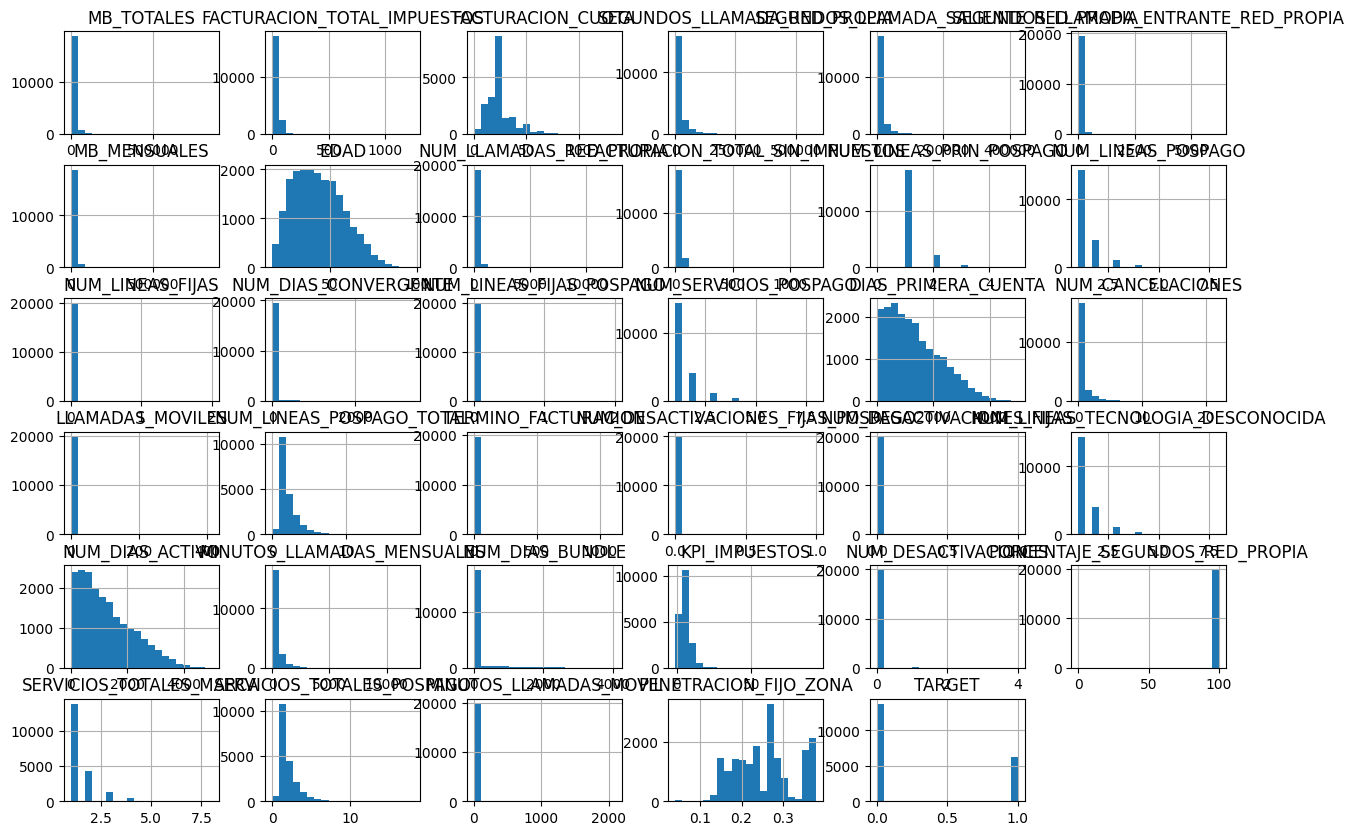

In [ ]:
datos.hist(figsize = (15,10), bins = 20)
plt.show()

Obtenemos la matriz de correlaciones de los datos.

<ipython-input-12-5c358123c506>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mcorr = X.corr(method = 'pearson')


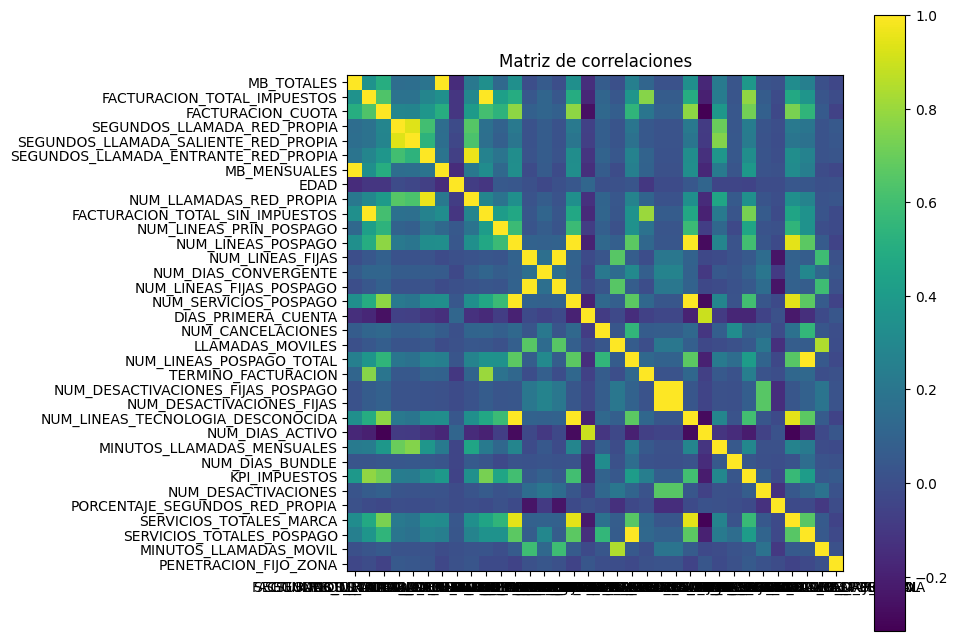

In [ ]:
mcorr = X.corr(method = 'pearson')
plt.figure(figsize = (8, 8))
plt.imshow(mcorr)
plt.colorbar()
plt.xticks(range(len(mcorr)), mcorr.columns)
plt.yticks(range(len(mcorr)), mcorr.columns)
plt.title('Matriz de correlaciones')
plt.show()

Como vemos hay algunas variables que estan muy correladas entre si, ya veremos como tratar con ellas en el preproceso.

Realizamos un boxplot de los datos.

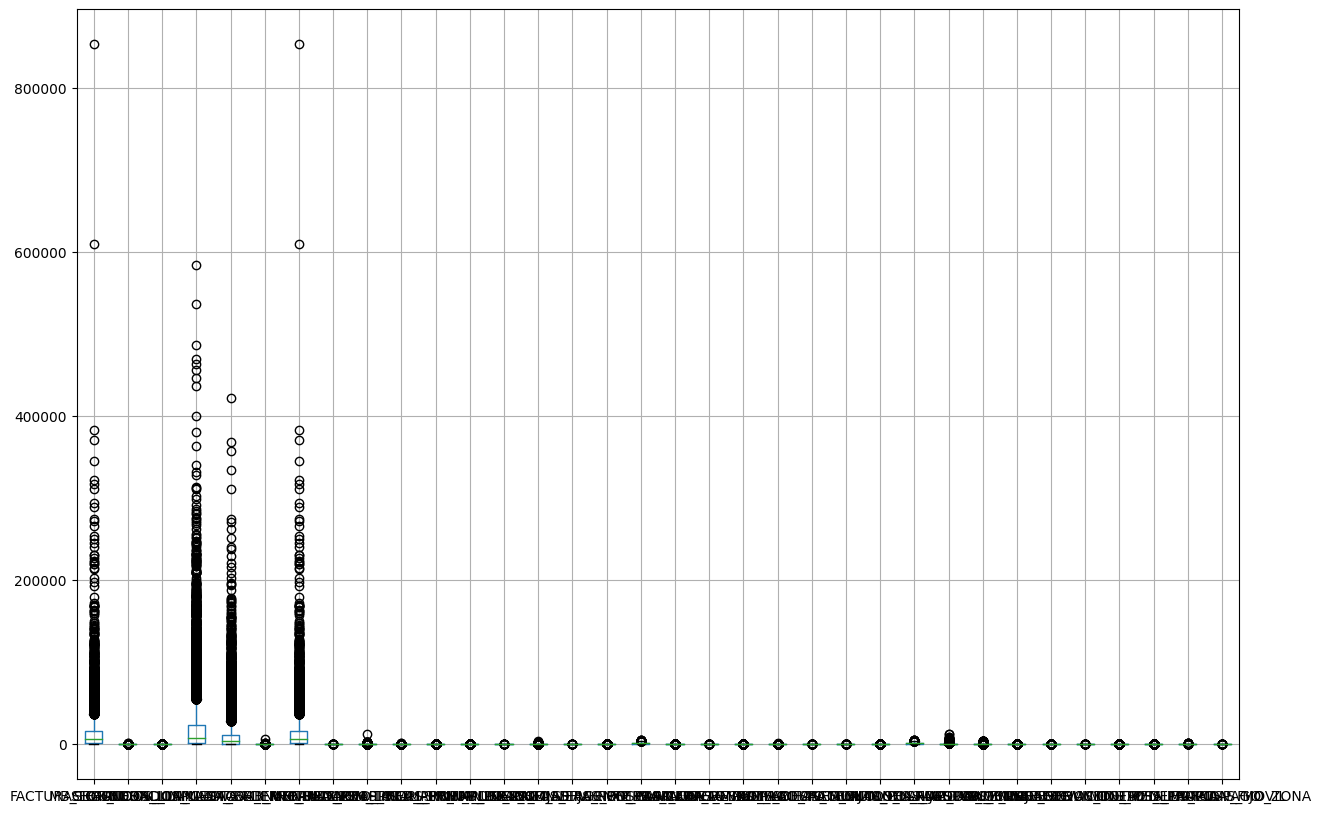

In [ ]:
X.boxplot(figsize = (15,10))
plt.show()

Hay algunas variables con muchos valores atipicos.

Obtenemos un grafico de la variable respuesta para ver si esta desbalanceada.

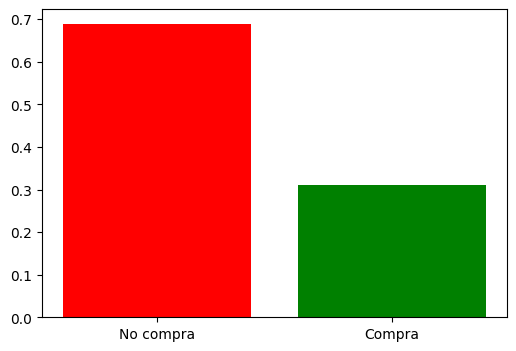

In [ ]:
y1 = y[y == 1]
y0 = y[y == 0]
porcentaje_y0 = len(y0)/len(datos)
porcentaje_y1 = len(y1)/len(datos)
porcentajes = [porcentaje_y0, porcentaje_y1]
etiquetas = ['No compra','Compra']
plt.figure(figsize = (6,4))
plt.bar(etiquetas, porcentajes,color = ['red','green'])
plt.show()

Como vemos, aproximadamente el 70% de las personas no compra un producto y el 30% si compra un producto.

Vamos a ver si el total de las respuestas difieren segun el mes en el que estemos.

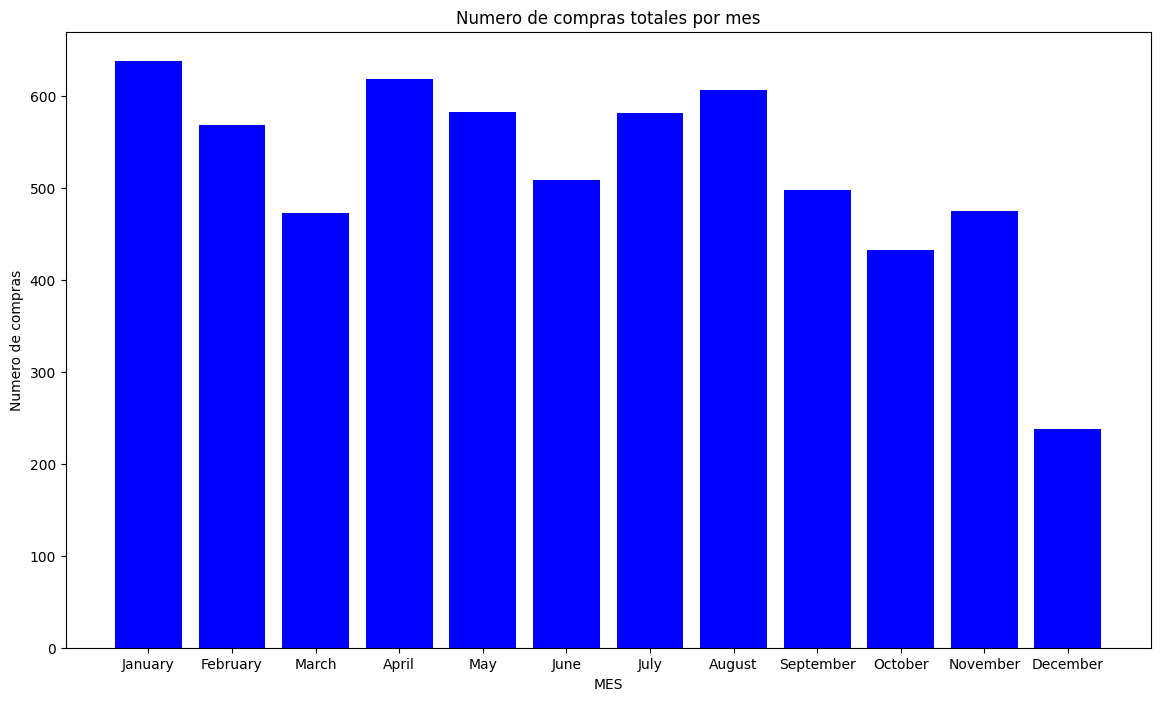

In [ ]:
datos_compra = datos[datos['TARGET'] == 1]
total_target_mes = datos.groupby(datos_compra['MES'])['TARGET'].value_counts()
mes = [calendar.month_name[i] for i in range(1, 13)]
plt.figure(figsize = (14,8))
plt.bar(mes, total_target_mes, color = 'blue')
plt.xticks(mes)
plt.xlabel('MES')
plt.ylabel('Numero de compras')
plt.title('Numero de compras totales por mes')
plt.show()

Los datos no varian mucho entre mes y mes, sino que permanecen mas o menos en la misma direccion.  

El unico mes que se puede extraviar de esta trayectoria es diciembre, que tiene un numero de compras bastante menor que el resto de meses.

## Preproceso

Una vez realizado un analisis exploratorio basico de los datos, podemos tratar con los problemas que presentan los datos.

Comenzamos eliminando las variables que tengan mas de 95% de correlacion con alguna otra variable.

La funcion que se ha utilizado para este proposito esta definida al principio del documento en la parte de la carga de paquetes.

In [ ]:
mcol = col_corr(mcorr,X)
mcol

,Columna1,Columna2,Correlacion
0,MB_MENSUALES,MB_TOTALES,0.999710
1,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_TOTAL_SIN_IMPUESTOS,0.996785
2,NUM_LLAMADAS_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,0.959292
6,NUM_LINEAS_POSPAGO,NUM_SERVICIOS_POSPAGO,1.000000
7,NUM_LINEAS_POSPAGO,NUM_LINEAS_TECNOLOGIA_DESCONOCIDA,1.000000
8,NUM_LINEAS_FIJAS,NUM_LINEAS_FIJAS_POSPAGO,1.000000
11,NUM_LINEAS_TECNOLOGIA_DESCONOCIDA,NUM_SERVICIOS_POSPAGO,1.000000
12,NUM_LINEAS_POSPAGO_TOTAL,SERVICIOS_TOTALES_POSPAGO,0.997317
13,NUM_DESACTIVACIONES_FIJAS,NUM_DESACTIVACIONES_FIJAS_POSPAGO,1.000000


Eliminamos las columnas que tengan mas sentido para nuestro proposito, en este caso, eliminamos las columnas:

1.   MB_TOTALES, pues ya tenemos los datos mensuales
2.   FACTURACION_TOTAL_SIN_IMPUESTOS, pues nos interesa mas la facturacion con impuestos
3.   SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA, pues nos interesa el numero de llamadas realizadas para la tarifa.
4.   NUM_LINEAS_POSPAGO, pues nos interesa el numero de servicios pospago y porque esta muy correlada tambien con NUM_LINEAS_TECNOLOGIA_DESCONOCIDA.
5.   NUM_LINEAS_FIJAS, pues nos interesa mas las que hay pospago.
6.   NUM_LINEAS_TECNOLOGIA_DESCONOCIDA, pues nos interesa el pospago total por servicios mas que por 1 servicio
7.   NUM_LINEAS_POSPAGO_TOTAL, pues nos interesa el pospago total por servicios mas que por 1 servicio.
8.   NUM_DESACTIVACIONES_FIJAS, pues nos interesa el numero de desactivaciones fijas pospago.

In [ ]:
col_elim = ['MB_TOTALES','FACTURACION_TOTAL_SIN_IMPUESTOS','SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA','NUM_LINEAS_POSPAGO',
            'NUM_LINEAS_FIJAS','NUM_LINEAS_TECNOLOGIA_DESCONOCIDA','NUM_LINEAS_POSPAGO_TOTAL','NUM_DESACTIVACIONES_FIJAS']
X = X.drop(col_elim, axis = 1)

Vemos que variables son categoricas, considerando como variables categoricas aquellas con <= 12 categorias.

La funcion que se ha utilizado para este proposito esta definida al principio del documento en la parte de la carga de paquetes.

In [ ]:
X_cat = cata(X)
print(X_cat)

                            VARIABLE  NUMERO CATEGORIAS
0                                MES                 12
1            NUM_LINEAS_PRIN_POSPAGO                  6
2           NUM_LINEAS_FIJAS_POSPAGO                  3
3              NUM_SERVICIOS_POSPAGO                  8
4  NUM_DESACTIVACIONES_FIJAS_POSPAGO                  2
5                NUM_DESACTIVACIONES                  5
6            SERVICIOS_TOTALES_MARCA                  8


Ya tenemos las variables que hemos considerado como categoricas, ahora podemos dividir las variables en numericas y categoricas.

In [ ]:
col_cat = X_cat['VARIABLE']
X_num = X.drop(col_cat, axis = 1)
col_num = X_num.columns

Definimos un pipeline para variables categoricas y otro para variables numericas.
1. En el pipeline para variables numericas sustituimos los valores faltantes por la media y estandarizamos los datos para que tengan media 0 y desviacion tipica 1.
2. En el pipeline para variables categoricas sustituimos los valores faltantes por la moda y transformamos las variables categoricas en binarias

In [ ]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'mean')),
                         ('scaler', StandardScaler())])

cat_pipeline = Pipeline([('onehot', OneHotEncoder()),
                         ('imputer', SimpleImputer(strategy = 'most_frequent'))])

Aplicamos los pipelines a las variables correspondientes.

In [ ]:
preproceso = ColumnTransformer([('num', num_pipeline, col_num),
                                ('cat', cat_pipeline, col_cat)])

Aplicamos los pipeline que se acaban de definir a los datos y obtenemos los datos transformados.

In [ ]:
X_trans = preproceso.fit_transform(X)
col_preproceso = col_num.tolist() + preproceso.named_transformers_['cat']['onehot'].get_feature_names_out(col_cat).tolist()
X_trans = pd.DataFrame(X_trans, columns = col_preproceso)
X_trans[:2]

,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,MB_MENSUALES,EDAD,NUM_LLAMADAS_RED_PROPIA,NUM_DIAS_CONVERGENTE,DIAS_PRIMERA_CUENTA,NUM_CANCELACIONES,...,NUM_DESACTIVACIONES_3,NUM_DESACTIVACIONES_4,SERVICIOS_TOTALES_MARCA_1,SERVICIOS_TOTALES_MARCA_2,SERVICIOS_TOTALES_MARCA_3,SERVICIOS_TOTALES_MARCA_4,SERVICIOS_TOTALES_MARCA_5,SERVICIOS_TOTALES_MARCA_6,SERVICIOS_TOTALES_MARCA_7,SERVICIOS_TOTALES_MARCA_8
0,-1.016049,-1.930632,-0.466380,-0.484311,-0.603227,-0.353583,-0.451116,-0.141392,-1.365841,-0.590094,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.295181,0.097431,-0.189425,-0.060378,0.299828,-1.345412,-0.019420,-0.141392,-0.997233,0.253741,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Una vez finalizada la etapa del preproceso de los datos, debemos decidir que metodos de aprendizaje utilizar para crear el modelo que mejor se ajusta a los datos.

## Modelo Arbol de Clasificacion

Aplicamos un modelo de arbol de decision para el problema de clasificacion pues queremos ver las reglas que se aplican para decidir si un cliente compra o no un producto.

Dividimos los datos en entrenamiento y test utilizando un holdout = 33%; es decir, 2/3 de los datos se dedican al entrenamiento del modelo y 1/3 a la evaluacion del modelo.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size = (1/3), random_state = 129)

Ajustamos hiperparametros con una busqueda de hiperparametros en rejilla (grid search), utilizamos validacion interna cruzada con k-fold (k = 10) y como metrica de evaluacion utilizamos la accuracy.

Los hiperparametros que se van a ajustar son la maxima profundida del arbol y el numero minimo de instancias necesarias para dividir el arbol.

In [ ]:
param_grid = {'max_depth': range(3, 11),
              'min_samples_split': range(5, 11)}
arbol = DecisionTreeClassifier()
inner_cv = KFold(n_splits = 10, shuffle = True, random_state = 129)
grid_search = GridSearchCV(arbol, param_grid, cv = inner_cv, scoring = 'accuracy')

Como validacion externa se utiliza el holdout al 33% y entrenamos el modelo con los datos de entrenamiento.

In [ ]:
np.random.seed(129)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=129, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(3, 11),
                         'min_samples_split': range(5, 11)},
             scoring='accuracy')

Vemos cuales son los mejores valores de los hiperparametros y ajustamos el mejor arbol.

In [ ]:
mejor_arbol = grid_search.best_estimator_
print(grid_search.best_params_)

{'max_depth': 4, 'min_samples_split': 5}


Podemos obtener los scores para los datos de entrenamiento y de test con el umbral que viene definido por defecto.

In [ ]:
acc_train = (grid_search.best_score_)
predicciones = mejor_arbol.predict(X_test)
acc_test = accuracy_score(predicciones, y_test)
print(f'Obtenemos para el conjunto de entrenamiento accuracy = {acc_train}  y para los datos de test accuracy = {acc_test}')

Obtenemos para el conjunto de entrenamiento accuracy = 0.6888170318441679  y para los datos de test accuracy = 0.6919154042297885


En vez de utilizar el umbral que viene definido por defecto, utilizamos un umbral que definimos nosotros.

Calculamos ahora probabilidades de las las predicciones para los datos de test.

In [ ]:
y_pred_test = mejor_arbol.predict_proba(X_test)[:,1]

Calculamos la ROC-AUC para los datos de test.

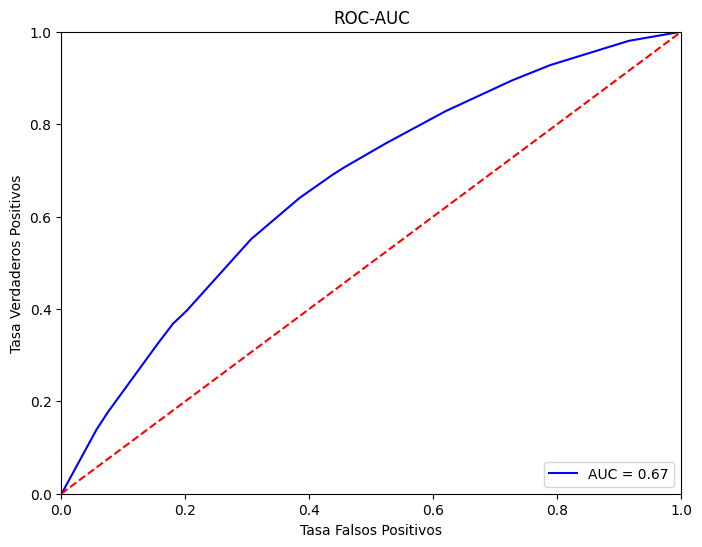

In [ ]:
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
roc_auc_curve(fpr_test, tpr_test, roc_auc_test)

Obtenemos la accuracy en funcion del umbral, que se obtiene a partir de una funcion definida al inicio del documento.

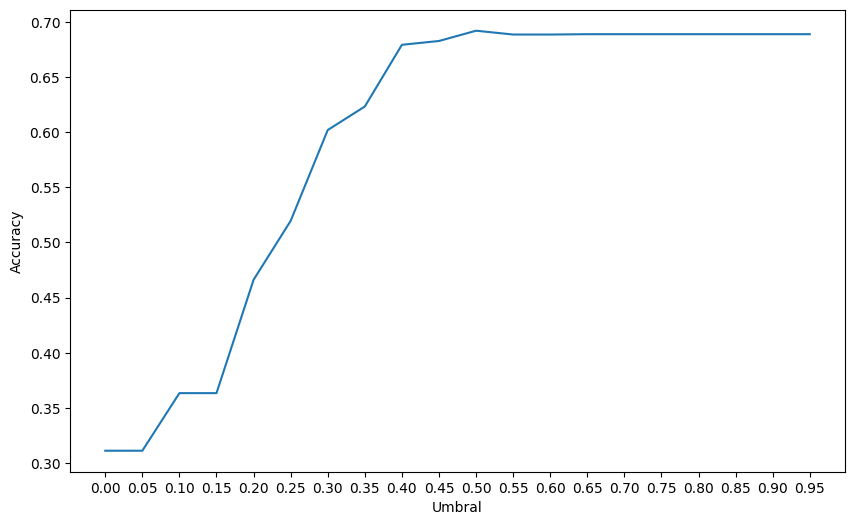

El mejor umbral = 0.5, para el cual se obtiene una accuracy = 0.6919154042297885


In [ ]:
umbral_arbol()

Calculamos las predicciones del modelo para el mejor umbral y creamos la matriz de confusion.

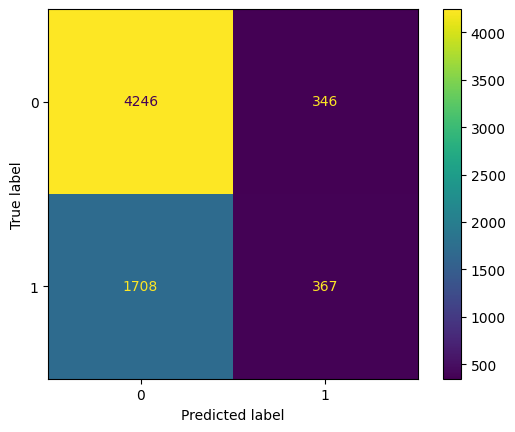

In [ ]:
umbral = 0.5
y_umbral_test = 1*(y_pred_test > umbral)
cm = metrics.confusion_matrix(y_test, y_umbral_test, labels = mejor_arbol.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = mejor_arbol.classes_)
disp.plot()
plt.show()

Así, obtenemos 4246 verdaderos positivos y 346 falsos positivos, obtenemos 367 verdaderos negativos y 1708 falsos negativos.

La formula para obtener la accuracy es verdaderos positivos + verdaderos negativos entre total de instancias.

In [ ]:
accuracy_cm = (cm[0,0] + cm[1,1])/len(y_test)
print(f'Segun la matriz de confusion para el umbral definido, accuracy = {accuracy_cm}')

Segun la matriz de confusion para el umbral definido, accuracy = 0.6919154042297885


Mostramos una visualizacion del arbol de decision.

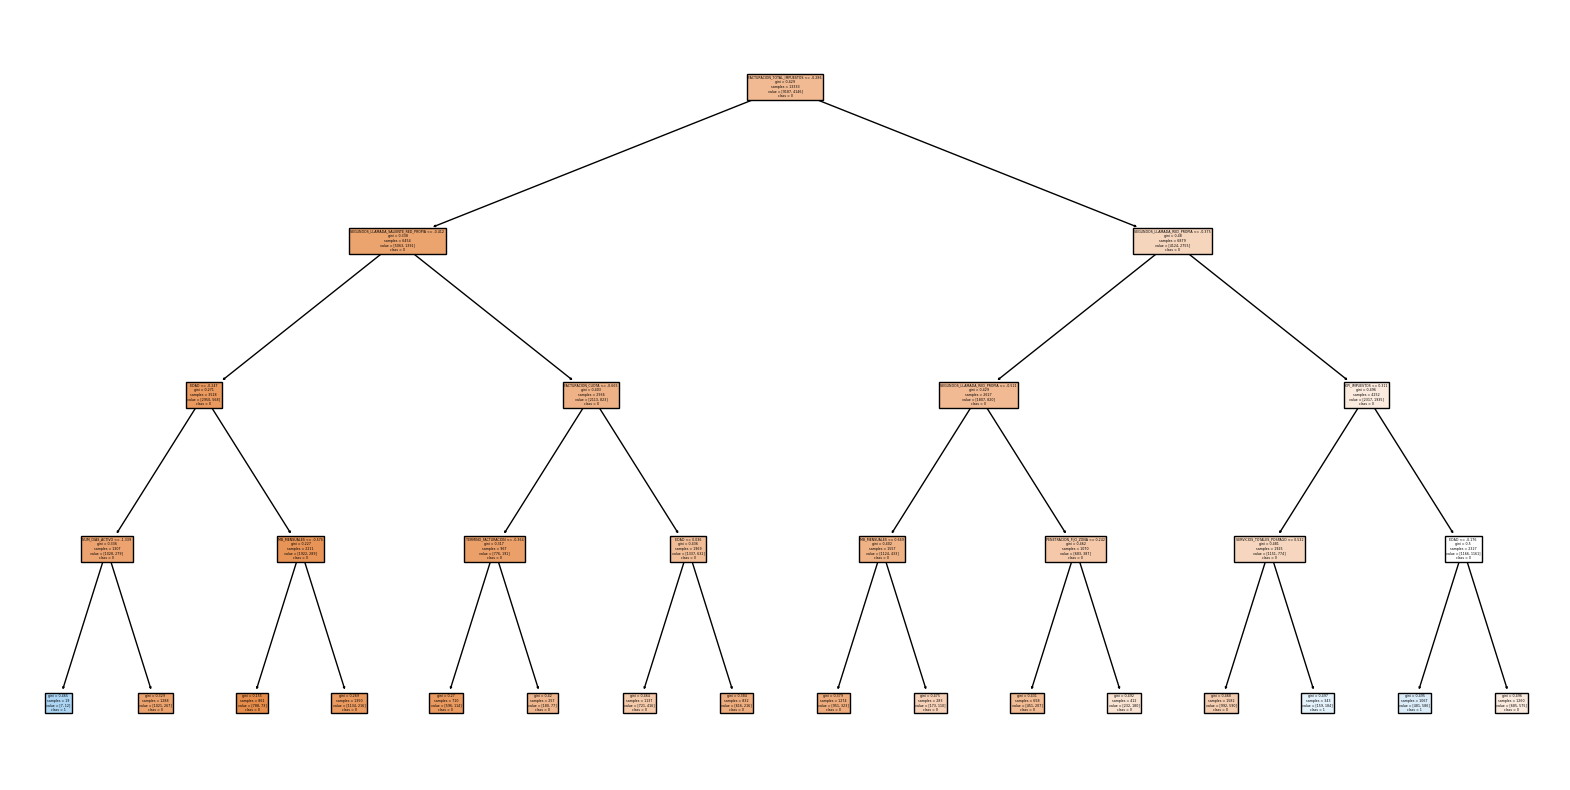

In [ ]:
col_x = X_trans.columns.tolist()
target = list(map(str, y.unique()))
plt.figure(figsize = (20, 10))
plot_tree(mejor_arbol, filled = True, feature_names = col_x, class_names = target)
plt.show()

## Modelo Redes Neuronales Perceptrón Multicapa

El otro modelo que se ha considerado como metodo de aprendizaje es el modelo de redes neuronales para problemas de clasificacion.

Creamos las capas de las redes neuronales:
1. Vamos a utilizar en la capa de entrada , una variable de entrada por cada columna de los datos.
2. En la primera capa oculta utilizamos 30 neuronas
3. En la segunda capa oculta utilizamos 20 neuronas
4. En la ultima capa utilizamos 1 sola neurona, porque queremos 1 unico resultado.
5. Ademas, en todas las capas ocultas vamos a utilizar la funcion relu como funcion de activacion, excepto para la capa de salida que utilizamos la funcion softmax, porque tenemos un problema de clasificacion.


In [ ]:
cols_x = len(X_trans.columns)
nn = Sequential()
nn.add(Dense(30, input_dim = cols_x, activation = 'relu'))
nn.add(Dense(20, activation = 'relu'))
nn.add(Dense(1, activation = 'sigmoid'))

Definimos la función de pérdida que, dado que es un problema de clasificacion, vamos a utilizar la entropia cruzada categorica.

Tambien vamos a utilizar el optimizador Adam y como metrica de evaluacion del modelo utilizamos la accuracy, para poder comparar ambos modelos.

In [ ]:
nn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Entrenamos el modelo con los datos que hemos dividido antes en entrenamiento y test.

Para ello vamos a utilizar un tamaño del lote de 4000 instancias y utilizamos 30 epocas.

In [ ]:
nn.fit(X_train, y_train, epochs = 30, batch_size = 4000, validation_data = (X_test, y_test))

Epoch 1/30
4/4 [==============================] - 1s 88ms/step - loss: 0.7035 - accuracy: 0.4748 - val_loss: 0.6904 - val_accuracy: 0.5793
Epoch 2/30
4/4 [==============================] - 0s 23ms/step - loss: 0.6767 - accuracy: 0.6185 - val_loss: 0.6665 - val_accuracy: 0.6603
Epoch 3/30
4/4 [==============================] - 0s 22ms/step - loss: 0.6536 - accuracy: 0.6739 - val_loss: 0.6465 - val_accuracy: 0.6795
Epoch 4/30
4/4 [==============================] - 0s 26ms/step - loss: 0.6349 - accuracy: 0.6885 - val_loss: 0.6303 - val_accuracy: 0.6832
Epoch 5/30
4/4 [==============================] - 0s 23ms/step - loss: 0.6199 - accuracy: 0.6912 - val_loss: 0.6178 - val_accuracy: 0.6862
Epoch 6/30
4/4 [==============================] - 0s 27ms/step - loss: 0.6087 - accuracy: 0.6930 - val_loss: 0.6086 - val_accuracy: 0.6885
Epoch 7/30
4/4 [==============================] - 0s 24ms/step - loss: 0.6007 - accuracy: 0.6950 - val_loss: 0.6024 - val_accuracy: 0.6906
Epoch 8/30
4/4 [===========

Creamos un grafico para ver la accuracy en entrenamiento frente a la accuracy en validacion en funcion del numero de epocas.

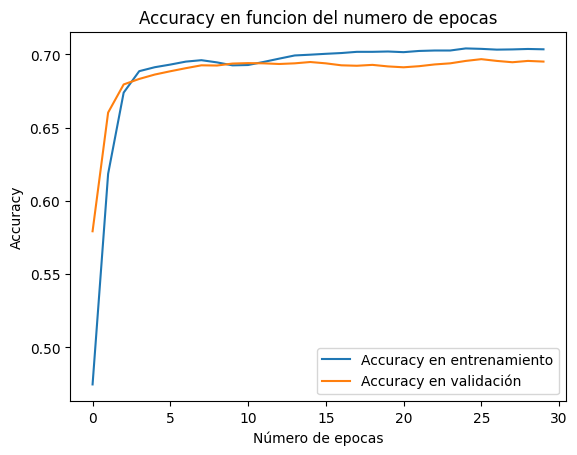

In [ ]:
plt.plot(nn.history.history['accuracy'], label = 'Accuracy en entrenamiento')
plt.plot(nn.history.history['val_accuracy'], label = 'Accuracy en validación')
plt.xlabel('Número de epocas')
plt.ylabel('Accuracy')
plt.title('Accuracy en funcion del numero de epocas')
plt.legend(loc = 'lower right')
plt.show()

Como vemos la accuracy a partir de las 3 epocas se mantiene mas o menos constante; es decir, a partir de la tercera epoca ya no se obtiene una mejora significante en la accuracy, tanto para test como para entrenamiento.

Calculamos las predicciones para los datos de test.

In [ ]:
y_pred_test = nn.predict(X_test)

209/209 [==============================] - 1s 2ms/step


Calculamos la ROC-AUC para los datos de test.

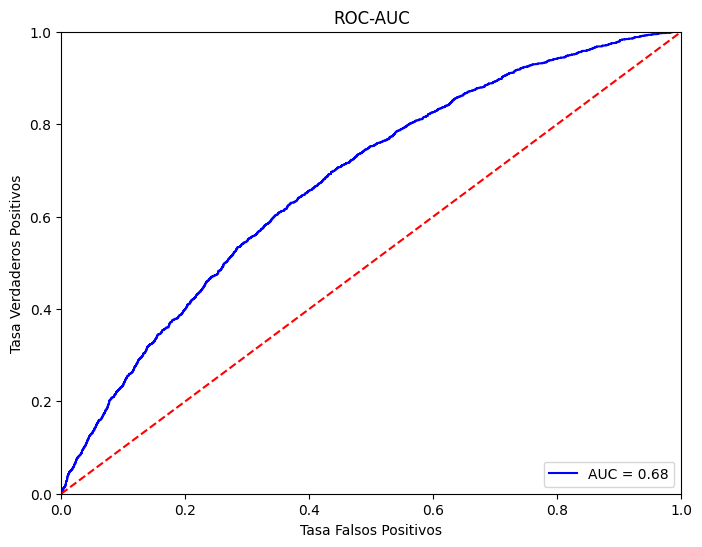

In [ ]:
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
roc_auc_curve(fpr_test, tpr_test, roc_auc_test)

Definimos los umbrales en funcion del accuracy, que se obtienen a partir de una funcion definida al inicio del documento.

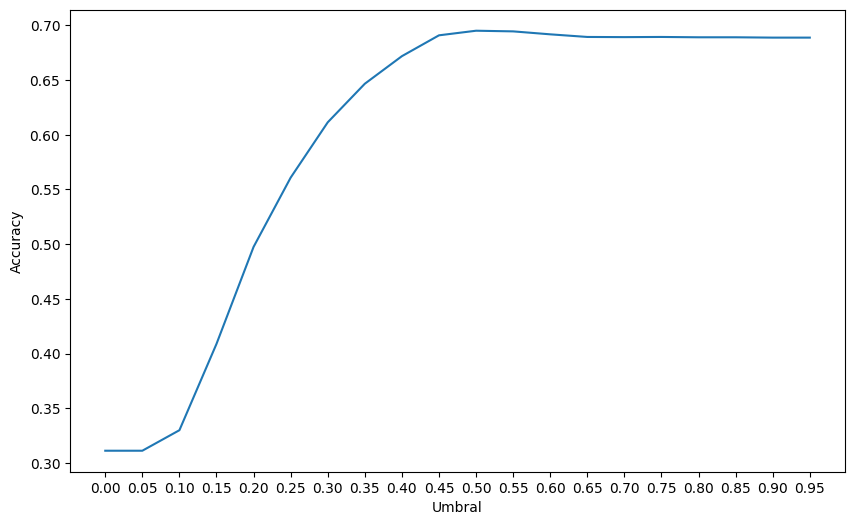

El mejor umbral = 0.5, para el cual se obtiene una accuracy = 0.6950652467376631


In [ ]:
umbral_nn()

Obtenemos la matriz de confusion para el mejor umbral.

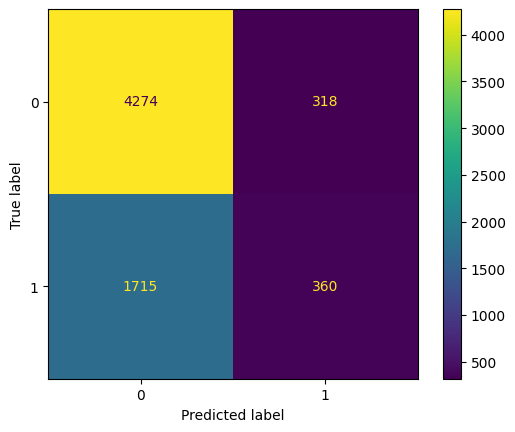

In [ ]:
umbral = 0.5
y_umbral_test = 1*(y_pred_test > umbral)
cm = metrics.confusion_matrix(y_test, y_umbral_test, labels = mejor_arbol.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = mejor_arbol.classes_)
disp.plot()
plt.show()

Así, obtenemos 4274 verdaderos positivos y 318 falsos positivos, obtenemos 360 verdaderos negativos y 1715 falsos negativos.

La formula para obtener la accuracy es verdaderos positivos + verdaderos negativos entre total de instancias.

In [ ]:
accuracy_cm = (cm[0,0] + cm[1,1])/len(y_test)
print(f'Segun la matriz de confusion para el umbral definido, accuracy = {accuracy_cm}')

Segun la matriz de confusion para el umbral definido, accuracy = 0.6950652467376631


## Conclusiones

Si comparamos los 2 metodos de aprendizaje que se han utilizado, obtenemos que los resultados en terminos de acccuracy son muy similares. Con el arbol de clasificacion obtenemos una accuracy = 0.692 mientras que con las redes neuronales se obtiene una acuracy = 0.695.

El tiempo de ejecucion del arbol ha sido bastante mayor que el del modelo de redes neuronales. Esto es asi porque en el arbol buscamos cuales son los mejores valores de los hiperparametros con una busqueda en rejilla (grid search). Es decir, probamos todas las combinaciones posibles de hiperparametros y se decide cual es la configuracion de hiperparametros con la que se obtiene un mejor score para el modelo. Mientras que en las redes neuronales establecemos los hiperparametros numero de neuronas en cada capa oculta,  tamaño del lote y numero de epocas de forma manual.

Ambos modelos proporcionan una accuracy bastante decente para los datos de entrenamiento y para los datos de test, por lo cual los modelos generalizan bastante bien y no se han sobreajustado a los datos de entrenamiento.